In [174]:
import os
import ipynb
import warnings
from sklearn.exceptions import FitFailedWarning, ConvergenceWarning 

import numpy as np
import pandas as pd
import seaborn as sns

import statistics
from scipy.stats import loguniform

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.utils._testing import ignore_warnings 
from sklearn.metrics import classification_report

from ipynb.fs.full.preprocessing import preprocessing #import preprocessing class from preprocessing.ipynb

In [6]:
#option 1: call preprocessing class to generate dataframes
prep_dwt8 = preprocessing(file_path = '/Users/jhbyun/Documents/685-Pr/ovarian-cancer-classification/data/DWT_8702.csv') #initialize class for DWT_8702
dwt8 = prep_dwt8.label_df() #generate dataframe with labels

prep_wp8 = preprocessing(file_path = '/Users/jhbyun/Documents/685-Pr/ovarian-cancer-classification/data/WPD_Wang_8702.csv') #initialize class for WPD_Wang_8702
wp8 = prep_wp8.label_df()

'''
#option 2: restore dataframes if previously stored in 00_EDA.ipynb
%store -r dwt8 
dwt8 = dwt8

%store -r wp8
wp8 = wp8
'''

'\n#option to restore dataframes if previously stored from 00_EDA.ipynb\n%store -r dwt8 \ndwt8 = dwt8\n\n%store -r wp8\nwp8 = wp8\n'

## Logistic Regression (default parameters)

In [90]:
def log_reg(df, n_iter=1000):

    df = df
    x = df.loc[:, df.columns != 'state'] #features
    y = df.loc[:, df.columns == 'state'] #supervisor

    eval_metrics = { #empty dictionary to store classification report
        '0_precision': [],
        '0_recall': [],
        '0_f1-score': [],
        '0_support': [],

        '1_precision': [],
        '1_recall': [],
        '1_f1-score': [],
        '1_support': [],
        
        'accuracy': [],
        'accuracy_train': [],
    }

    for i in range(n_iter): 

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)

        scaler = StandardScaler()    
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)

        log_reg_model = LogisticRegression(class_weight='balanced') #default 
        log_reg_model.fit(x_train, y_train.values.ravel())
        
        y_pred = log_reg_model.predict(x_test)
        report = classification_report(y_test, y_pred, output_dict=True)

        y_pred_train = log_reg_model.predict(x_train)
        report_train = classification_report(y_train, y_pred_train, output_dict=True)

        eval_metrics['0_precision'].append(report['0']['precision']) #store classification_report values in dictionary
        eval_metrics['0_recall'].append(report['0']['recall'])
        eval_metrics['0_f1-score'].append(report['0']['f1-score'])
        eval_metrics['0_support'].append(report['0']['support'])

        eval_metrics['1_precision'].append(report['1']['precision'])
        eval_metrics['1_recall'].append(report['1']['recall'])
        eval_metrics['1_f1-score'].append(report['1']['f1-score'])
        eval_metrics['1_support'].append(report['1']['support'])

        eval_metrics['accuracy'].append(report['accuracy'])
        eval_metrics['accuracy_train'].append(report_train['accuracy'])

    eval_metrics_df = pd.DataFrame.from_dict(eval_metrics) #convert dictionary to dataframe

    return eval_metrics_df

In [277]:
acc_df_dwt8 = log_reg(dwt8, n_iter=1000)
acc_df_wp8 = log_reg(wp8, n_iter=1000)

In [286]:
print(round(acc_df_dwt8['accuracy'].mean(), 4)) #mean accuracy for dwt8
print(round(acc_df_wp8['accuracy'].mean(), 4)) #mean accuracy for wp8

0.9553
0.9599


### Cumulative Accuracy Plot Function

In [302]:
def cml_acc_plot(df, df_name, method=''):

    df['cml_accuracy'] = df['accuracy'].expanding().mean() #cumulative mean accuracy

    acc_fig, acc_ax = plt.subplots()
    sns.scatterplot(data=df, x=df.index, y='accuracy', marker='.', ax=acc_ax, palette='Set1', label='Accuracy', alpha=0.5)
    sns.lineplot(data=df, x=df.index, y='cml_accuracy', ax=acc_ax, label='Cumulative Mean Accuracy')

    acc_ax.set_title('Logistic Regression ' + 'with ' + method + ' for ' + df_name)
    acc_ax.set_ylabel('Accuracy')
    acc_ax.set_xlabel("nth Sampling Iteration")

    return acc_fig, acc_ax

/var/folders/11/868bvpf14xv49vlkglnffzvw0000gn/T/ipykernel_6850/1500256737.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x=acc_df.index, y='accuracy', marker='.', ax=acc_ax, palette='Set1', label='Accuracy', alpha=0.5)
/var/folders/11/868bvpf14xv49vlkglnffzvw0000gn/T/ipykernel_6850/1500256737.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x=acc_df.index, y='accuracy', marker='.', ax=acc_ax, palette='Set1', label='Accuracy', alpha=0.5)


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Logistic Regression: Default Parameters for WPD_Wang_8702'}, xlabel='nth Sampling Iteration', ylabel='Accuracy'>)

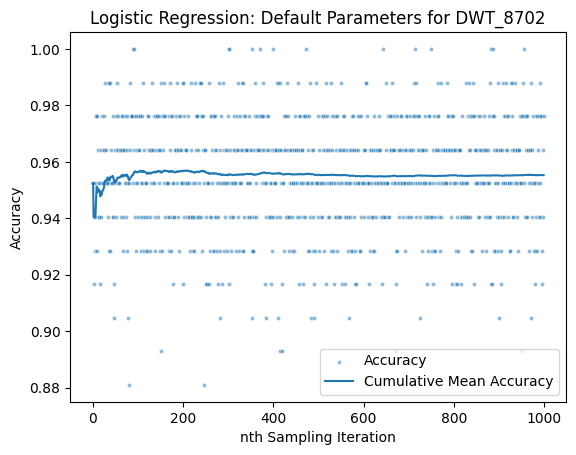

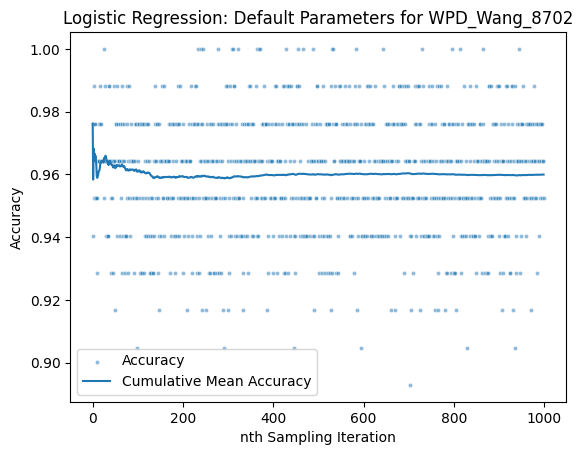

In [284]:
cml_acc_plot(df=acc_df_dwt8, df_name='DWT_8702') #run cumulative accuracy plot function for dwt8
cml_acc_plot(df=acc_df_wp8, df_name='WPD_Wang_8702') #run cumulative accuracy plot function for wp8

## Logistic Regression (random search)

In [104]:
@ignore_warnings(category=(ConvergenceWarning, FitFailedWarning, UserWarning)) #ignore warnings for forbidden parameter combinations between solvers and penalty in grid

def log_reg_random_search(df, n_iter = 100): 

    df = df
    x = df.loc[:, df.columns != 'state'] #features
    y = df.loc[:, df.columns == 'state'] #supervisor

    eval_metrics = { #empty dictionary to store classification report
        '0_precision': [],
        '0_recall': [],
        '0_f1-score': [],
        '0_support': [],

        '1_precision': [],
        '1_recall': [],
        '1_f1-score': [],
        '1_support': [],
        
        'accuracy': [],
        'accuracy_train': [],

    }

    for i in range(n_iter): 

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)

        scaler = StandardScaler()
        log_reg_model = LogisticRegression(class_weight='balanced')
        param_grid = {
            'log_reg__solver': ['newton-cg', 'lbfgs', 'liblinear'],
            'log_reg__penalty': ['l1', 'l2', 'elasticnet'],
            'log_reg__C': loguniform(1e-5, 100)
        }
        
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1) 
        pipeline = Pipeline(steps=[("scaler", scaler), ("log_reg", log_reg_model)])
        search = RandomizedSearchCV(pipeline, param_grid, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv) #n_iter = number of parameter settings that are sampled
        
        result = search.fit(x_train, y_train.values.ravel())
        y_pred = result.predict(x_test)
        report = classification_report(y_test, y_pred, output_dict=True)

        y_pred_train = result.predict(x_train)
        report_train = classification_report(y_train, y_pred_train, output_dict=True)

        eval_metrics['0_precision'].append(report['0']['precision']) #store classification_report values in dictionary
        eval_metrics['0_recall'].append(report['0']['recall'])
        eval_metrics['0_f1-score'].append(report['0']['f1-score'])
        eval_metrics['0_support'].append(report['0']['support'])

        eval_metrics['1_precision'].append(report['1']['precision'])
        eval_metrics['1_recall'].append(report['1']['recall'])
        eval_metrics['1_f1-score'].append(report['1']['f1-score'])
        eval_metrics['1_support'].append(report['1']['support'])

        eval_metrics['accuracy'].append(report['accuracy'])
        eval_metrics['accuracy_train'].append(report_train['accuracy'])

    eval_metrics_df = pd.DataFrame.from_dict(eval_metrics) #convert dictionary to dataframe

    return eval_metrics_df

In [287]:
acc_df_dwt8 = log_reg_random_search(dwt8, n_iter=500)
acc_df_wp8 = log_reg_random_search(wp8, n_iter=500)

In [288]:
print(round(acc_df_dwt8['accuracy'].mean(), 4)) #mean accuracy for dwt8
print(round(acc_df_wp8['accuracy'].mean(), 4)) #mean accuracy for wp8

0.9494
0.9544


/var/folders/11/868bvpf14xv49vlkglnffzvw0000gn/T/ipykernel_6850/698212994.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x=df.index, y='accuracy', marker='.', ax=acc_ax, palette='Set1', label='Accuracy', alpha=0.5)
/var/folders/11/868bvpf14xv49vlkglnffzvw0000gn/T/ipykernel_6850/698212994.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x=df.index, y='accuracy', marker='.', ax=acc_ax, palette='Set1', label='Accuracy', alpha=0.5)


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Logistic Regression with Random Search for WPD_Wang_8702'}, xlabel='nth Sampling Iteration', ylabel='Accuracy'>)

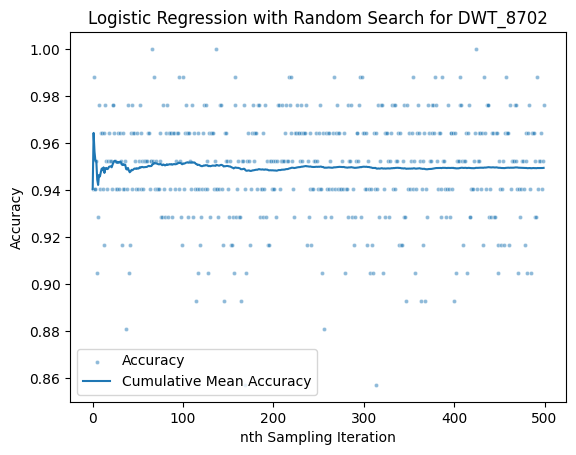

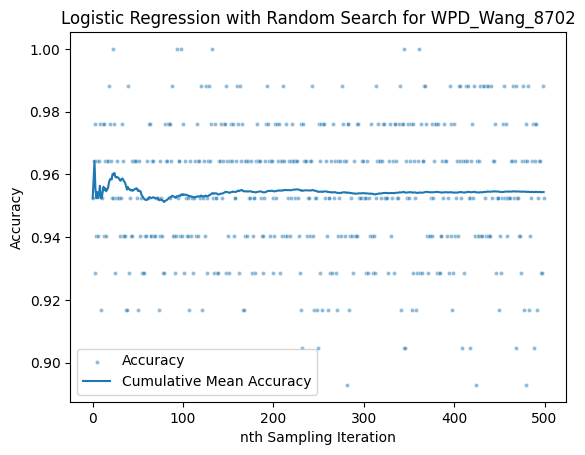

In [303]:
cml_acc_plot(df=acc_df_dwt8, df_name='DWT_8702', method='Random Search') #run cumulative accuracy plot function for dwt8
cml_acc_plot(df=acc_df_wp8, df_name='WPD_Wang_8702', method='Random Search') #run cumulative accuracy plot function for wp8

## Accuracy by files and n Fisher's features

In [81]:
prep_dwt8 = preprocessing(file_path = '/Users/jhbyun/Documents/685-Pr/ovarian-cancer-classification/data/DWT_8702.csv') #initialize class for DWT_8702
dwt8 = prep_dwt8.label_df()

prep_wp8 = preprocessing(file_path = '/Users/jhbyun/Documents/685-Pr/ovarian-cancer-classification/data/WPD_Wang_8702.csv') #initialize class for WPD_Wang_8702
wp8 = prep_wp8.label_df()

In [82]:
def accuracy_by_nfeatures(class_instance, file_name, default=True, n_features=29, n_iter=100): 
    
    acc_metrics = {} #empty dictionary to store accuracy metrics

    for i in range(1, n_features+1): #range of fisher's criterion values / # of features, inclusive
           
        df = class_instance.fishers(top_n=i) #class instance applied to create df with top n features for every for loop iteration

        if default==True: #default parameters for logistic regression 
            method = 'Logistic Regression: Default Parameters'
            eval_metrics_df = log_reg(df=df, n_iter=n_iter)
        else: #run random search for logistic regression
            method = 'Logistic Regression: Random Search'
            eval_metrics_df = log_reg_random_search(df=df, n_iter=n_iter)
        acc = eval_metrics_df['accuracy']
        acc_train = eval_metrics_df['accuracy_train']

        mean = statistics.mean(acc)
        stdev = statistics.stdev(acc)

        mean_train = statistics.mean(acc_train)
        stdev_train = statistics.stdev(acc_train)
        acc_metrics[str(i)] =list([i, file_name, mean, stdev, mean_train, stdev_train]) #store list in dictionary

    acc_metrics = pd.DataFrame.from_dict(acc_metrics) 
    acc_metrics = acc_metrics.T
    acc_metrics.columns = ['n_features', 'file_name', 'mean', 'stdev', 'mean_train', 'stdev_train']
    acc_metrics

    return acc_metrics

### Logistic Regression: Default Parameters

In [93]:
#call accuracy_by_nfeatures function for dwt8 and wp8; generates mean accuracy for training and testing sets
acc_metrics_dwt8 = accuracy_by_nfeatures(class_instance=prep_dwt8, file_name='DWT_8702', default=True, n_features=29, n_iter=300)
#acc_metrics_dwt8
acc_metrics_wp8 = accuracy_by_nfeatures(class_instance=prep_wp8, file_name='WPD_Wang_8702', default=True, n_features=29, n_iter=300)
#acc_metrics_wp8

In [94]:
#merge two dataframes on n_features
merged_logreg_default = acc_metrics_dwt8.merge(acc_metrics_wp8, how='right', on='n_features', suffixes=('_dwt8', '_wp8')) 
merged_logreg_default.head()

,n_features,file_name_dwt8,mean_dwt8,stdev_dwt8,mean_train_dwt8,stdev_train_dwt8,file_name_wp8,mean_wp8,stdev_wp8,mean_train_wp8,stdev_train_wp8
0,1,DWT_8702,0.782817,0.036542,0.785976,0.018429,WPD_Wang_8702,0.778532,0.039811,0.779645,0.02146
1,2,DWT_8702,0.875873,0.031349,0.882623,0.017968,WPD_Wang_8702,0.870278,0.030416,0.876607,0.015469
2,3,DWT_8702,0.915,0.026451,0.919034,0.012624,WPD_Wang_8702,0.901786,0.028372,0.909211,0.020099
3,4,DWT_8702,0.923095,0.025132,0.936252,0.012435,WPD_Wang_8702,0.906389,0.029042,0.918126,0.018033
4,5,DWT_8702,0.925516,0.024059,0.941203,0.012757,WPD_Wang_8702,0.931706,0.025391,0.943452,0.014615


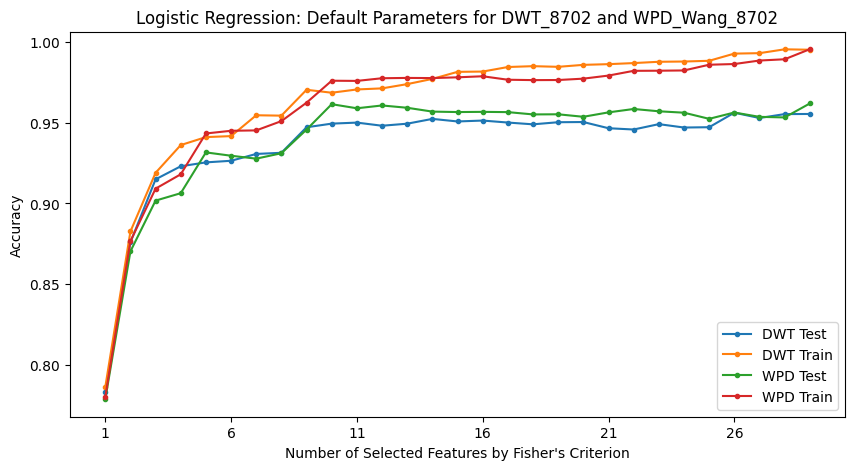

In [108]:
merged_logreg_default.plot(x='n_features', y=['mean_dwt8', 'mean_train_dwt8', 'mean_wp8', 'mean_train_wp8',], marker='.', 
           title='Logistic Regression: Default Parameters for DWT_8702 and WPD_Wang_8702',
           xlabel="Number of Selected Features by Fisher's Criterion", ylabel='Accuracy', 
           figsize=(10,5))

plt.legend(['DWT Test', 'DWT Train', 'WPD Test', 'WPD Train'], loc='lower right')

### Logistic Regression: Random Search

In [297]:
%%capture
acc_metrics_dwt8 = accuracy_by_nfeatures(class_instance=prep_dwt8, file_name='DWT_8702', default=False, n_features=29, n_iter=300) #call accuracy_by_nfeatures function for dwt8 and wp8; generates mean accuracy for training and testing sets; default=False for random search
#acc_metrics_dwt8
acc_metrics_wp8 = accuracy_by_nfeatures(class_instance=prep_wp8, file_name='WPD_Wang_8702', default=False, n_features=29, n_iter=300)
#acc_metrics_wp8

/Users/jhbyun/Documents/685-Pr/ovarian-cancer-classification/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhbyun/Documents/685-Pr/ovarian-cancer-classification/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative sol

In [298]:
#merge two dataframes on n_features
merged_logreg_randsearch = acc_metrics_dwt8.merge(acc_metrics_wp8, how='right', on='n_features', suffixes=('_dwt8', '_wp8')) 
merged_logreg_randsearch.head()

,n_features,file_name_dwt8,mean_dwt8,stdev_dwt8,mean_train_dwt8,stdev_train_dwt8,file_name_wp8,mean_wp8,stdev_wp8,mean_train_wp8,stdev_train_wp8
0,1,DWT_8702,0.77877,0.036149,0.785937,0.017754,WPD_Wang_8702,0.77246,0.041056,0.782525,0.020932
1,2,DWT_8702,0.872619,0.033959,0.882367,0.018484,WPD_Wang_8702,0.869802,0.028651,0.875996,0.014111
2,3,DWT_8702,0.910079,0.025109,0.92215,0.012,WPD_Wang_8702,0.899206,0.03011,0.91426,0.018589
3,4,DWT_8702,0.919762,0.023926,0.934536,0.012849,WPD_Wang_8702,0.903056,0.029874,0.916588,0.017623
4,5,DWT_8702,0.925873,0.024463,0.939783,0.013436,WPD_Wang_8702,0.929405,0.02181,0.944852,0.013188


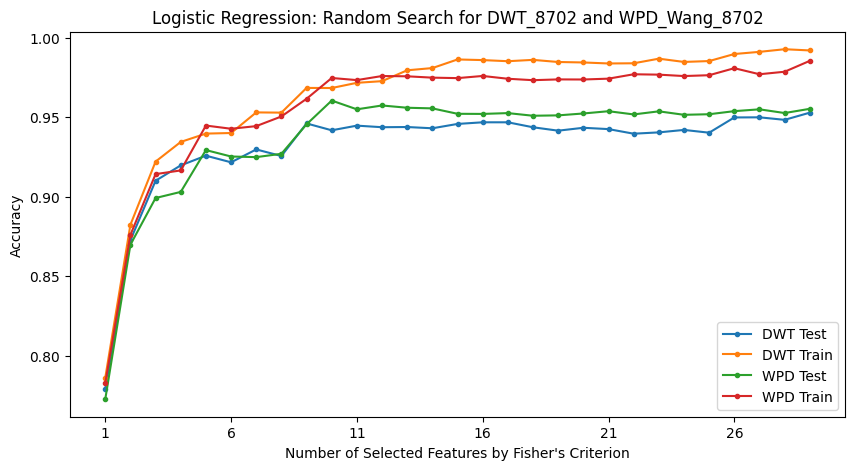

In [299]:
merged_logreg_randsearch.plot(x='n_features', y=['mean_dwt8', 'mean_train_dwt8', 'mean_wp8', 'mean_train_wp8',], marker='.', 
           title='Logistic Regression: Random Search for DWT_8702 and WPD_Wang_8702',
           xlabel="Number of Selected Features by Fisher's Criterion", ylabel='Accuracy', 
           figsize=(10,5))

plt.legend(['DWT Test', 'DWT Train', 'WPD Test', 'WPD Train'], loc='lower right')

## Logistic Regression: forward selection

In [300]:
@ignore_warnings(category=ConvergenceWarning)
def log_reg_selection(df, n_iter = 100, n_features=10): 

    feature_arr = [] #empty array to store selected features
    df = df
    x = df.loc[:, df.columns != 'state'] #features
    y = df.loc[:, df.columns == 'state'] #supervisor

    eval_metrics = { #empty dictionary to store classification report
        '0_precision': [],
        '0_recall': [],
        '0_f1-score': [],
        '0_support': [],

        '1_precision': [],
        '1_recall': [],
        '1_f1-score': [],
        '1_support': [],
        
        'accuracy': [],
    } 

    for i in range(n_iter): 

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)
        
        scaler = StandardScaler()
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test) 

        log_reg_model = LogisticRegression(class_weight='balanced', penalty=None) #no penalty/regularization since feature selection performed, defaults for everything else
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1)
        sfs = SequentialFeatureSelector(log_reg_model, direction='forward', scoring='accuracy', 
                                        n_features_to_select=n_features, cv=cv, n_jobs=-1)
    
        result = sfs.fit(x_train, y_train.values.ravel()) #fit with SequentialFeatureSelector
        #print(result.get_feature_names_out()) #print array of selected features
        x_train_sel = result.transform(x_train) #reduce training set to the selected features
        x_test_sel = result.transform(x_test) #reduce test set to the selected features

        sel_features_idx = sfs.get_support() #get boolean list of selected features
        sel_features = x.columns[sel_features_idx] #get column names of selected features
        feature_arr.append(sel_features) #store selected features in array

        result = log_reg_model.fit(x_train_sel, y_train.values.ravel()) #fit logistic regression model with filtered training set
        y_pred = result.predict(x_test_sel) #generate predictions with filtered test set
        report = classification_report(y_test, y_pred, output_dict=True) #generate classification report from test set 

        eval_metrics['0_precision'].append(report['0']['precision']) #store classification_report values in dictionary
        eval_metrics['0_recall'].append(report['0']['recall'])
        eval_metrics['0_f1-score'].append(report['0']['f1-score'])
        eval_metrics['0_support'].append(report['0']['support'])

        eval_metrics['1_precision'].append(report['1']['precision'])
        eval_metrics['1_recall'].append(report['1']['recall'])
        eval_metrics['1_f1-score'].append(report['1']['f1-score'])
        eval_metrics['1_support'].append(report['1']['support'])

        eval_metrics['accuracy'].append(report['accuracy'])

    eval_metrics_df = pd.DataFrame.from_dict(eval_metrics) #convert dictionary to dataframe

    feature_arr = np.asarray(feature_arr) #convert list to np array
    feature_arr_flat = np.ravel(feature_arr) #flatten np array

    return eval_metrics_df, feature_arr_flat

### DWT_8702

In [301]:
%%capture
acc_df_forward_dwt8, feature_arr_flat_dwt8 = log_reg_selection(dwt8, n_iter=300, n_features=10) #run forward feature selection for dwt8, 10 features

/Users/jhbyun/Documents/685-Pr/ovarian-cancer-classification/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhbyun/Documents/685-Pr/ovarian-cancer-classification/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative sol

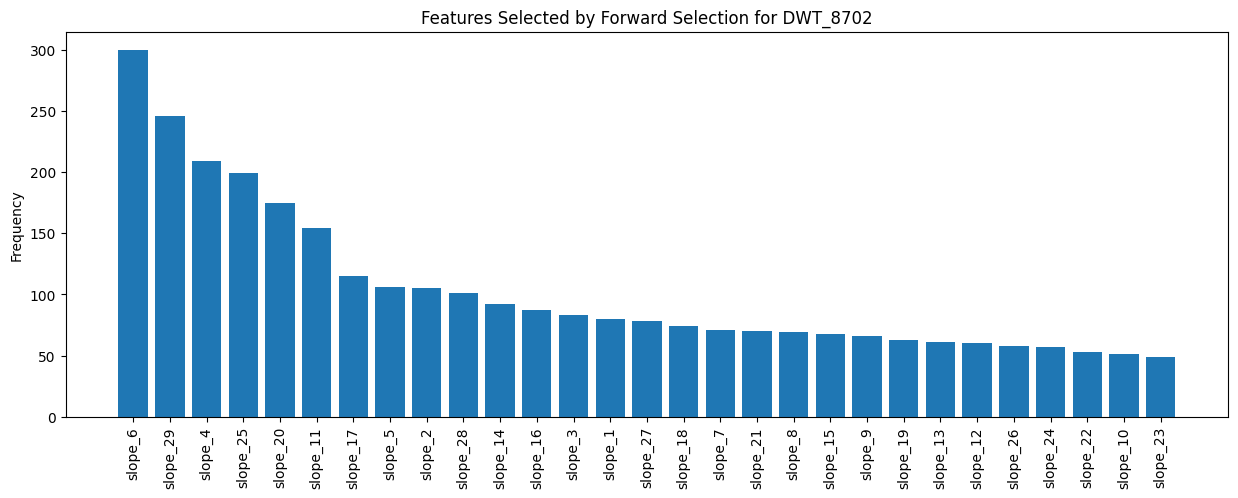

In [303]:
feature_count_arr_dwt8 = np.unique(feature_arr_flat_dwt8, return_counts=True)
feature_count_df_dwt8 = pd.DataFrame(feature_count_arr_dwt8).T
feature_count_df_dwt8.columns = ['feature', 'frequency']
feature_count_df_dwt8 = feature_count_df_dwt8.sort_values('frequency', ascending=False)
feature_count_top10_dwt8 = feature_count_df_dwt8.head(10) #top 10 features by frequency

plt.figure(figsize=(15,5))
plt.bar(feature_count_df_dwt8['feature'], feature_count_df_dwt8['frequency'])
plt.title("Features Selected by Forward Selection for DWT_8702")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [304]:
top10_features = feature_count_top10_dwt8['feature'].tolist()
top10_features.append('state') 

dwt8_forward_filtered = dwt8.loc[:,top10_features] #filter dwt8 dataframe to only include top 10 features
dwt8_forward_filtered.head()

,slope_6,slope_29,slope_4,slope_25,slope_20,slope_11,slope_17,slope_5,slope_2,slope_28,state
0,-2.853814,-2.390560,-2.567832,-2.868000,-2.931648,-2.409633,-2.747051,-2.714483,-2.390083,-2.616103,1
1,-2.664095,-2.344442,-2.322088,-2.815763,-3.017540,-2.428556,-2.825209,-2.544736,-2.243269,-2.701947,1
2,-2.848399,-2.603805,-2.477289,-2.872999,-3.043497,-2.089429,-2.786237,-2.450869,-2.286579,-2.744103,1
3,-2.738331,-2.401006,-2.373840,-2.847411,-3.056333,-1.990729,-2.546528,-2.467567,-2.357384,-2.614736,1
4,-2.718791,-2.421083,-2.333251,-2.842104,-3.051181,-1.712213,-2.619271,-2.608106,-2.423288,-2.682061,1


In [305]:
acc_df_dwt8_forward_filtered = log_reg_random_search(dwt8_forward_filtered, n_iter=300) #run random search for filtered dataframe

print(round(acc_df_dwt8_forward_filtered['accuracy'].mean(), 4)) #mean accuracy for forward selection filtered dataframe

0.9541


### WPD_Wang_8702

In [306]:
%%capture
#RUN
acc_df_forward_wp8, feature_arr_flat_wp8 = log_reg_selection(wp8, n_iter=300, n_features=10)

/Users/jhbyun/Documents/685-Pr/ovarian-cancer-classification/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhbyun/Documents/685-Pr/ovarian-cancer-classification/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative sol

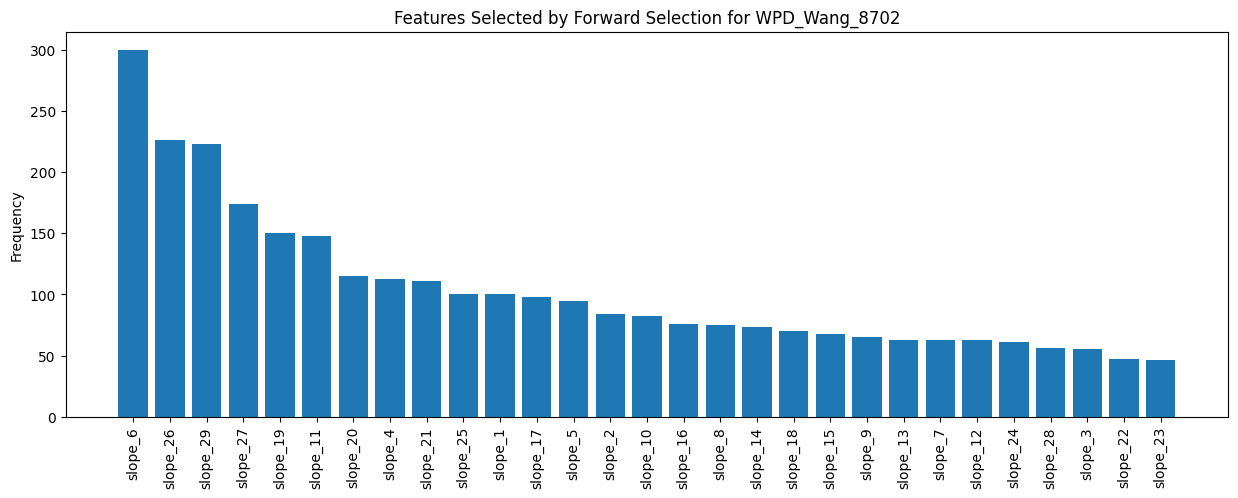

In [315]:
feature_count_arr_wp8 = np.unique(feature_arr_flat_wp8, return_counts=True)
feature_count_df_wp8 = pd.DataFrame(feature_count_arr_wp8).T
feature_count_df_wp8.columns = ['feature', 'frequency']
feature_count_df_wp8 = feature_count_df_wp8.sort_values('frequency', ascending=False)
feature_count_top10_wp8 = feature_count_df_wp8.head(10) #top 10 features by frequency

plt.figure(figsize=(15,5))
plt.bar(feature_count_df_wp8['feature'], feature_count_df_wp8['frequency'])
plt.title("Features Selected by Forward Selection for WPD_Wang_8702")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [316]:
top10_features = feature_count_top10_wp8['feature'].tolist()
top10_features.append('state') 

wp8_forward_filtered = wp8.loc[:,top10_features] #filter dwt8 dataframe to only include top 10 features

acc_df_wp8_forward_filtered = log_reg_random_search(wp8_forward_filtered, n_iter=300) #run random search for filtered dataframe

print(round(acc_df_wp8_forward_filtered['accuracy'].mean(), 4)) #mean accuracy for forward selection filtered dataframe

0.9655


## Scratchpad

Which features are selected with selection? Significance of features (wilcoxon rank-sum test) compare against features selected by Fisher's criterion

DWT_8702 in progress
WPD_Wang_8702 in progress


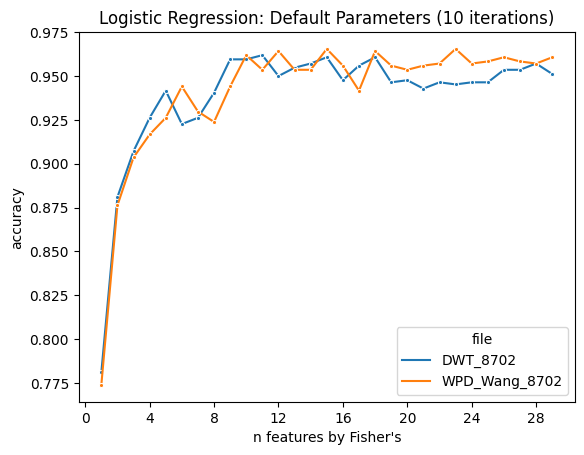

In [24]:
#full set of features, default parameters  for logistic regression
acc_metrics, pl = accuracy_plot(files = ['DWT_8702', 'WPD_Wang_8702'], #files = ['DWT_4302', 'DWT_8702', 'WPD_Wang_4302', 'WPD_Wang_8702'], 
                                default=True, n_features=29, n_iter=10)

Text(0.5, 0, "n features selected by Fisher's Criterion")

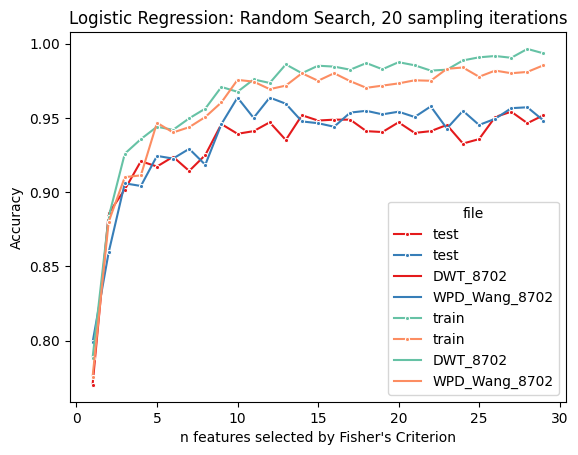

In [179]:
acc_metrics = pd.DataFrame.from_dict(acc_metrics).T
acc_metrics.columns = ['file', 'n_features', 'mean', 'stdev', 'mean_train', 'stdev_train']
acc_metrics = acc_metrics.reset_index(drop=True)

"""
#PART 2: PLOT ACCURACY METRICS FOR EACH FILE
pl = sns.lineplot(data=acc_metrics, x='n_features', y='mean', hue='file', marker='.')
pl.xaxis.set_major_locator(MaxNLocator(integer=True))
pl.set(title=(method + " (" + str(n_iter) + " iterations)"), xlabel="n features by Fisher's", ylabel='accuracy')
"""

fig, ax = plt.subplots()

sns.lineplot(data=acc_metrics, x='n_features', y='mean', hue='file', marker='.', ax=ax, palette='Set1', label='test')

sns.lineplot(data=acc_metrics, x='n_features', y='mean_train', hue='file', marker='.', ax=ax, palette='Set2', label='train')

ax.set_title('Logistic Regression: Random Search, 20 sampling iterations')
ax.set_ylabel('Accuracy')
ax.set_xlabel("n features selected by Fisher's Criterion")

#fig.set(title='Logistic Regression: Default Parameters, 1000 iterations', xlabel="n features by Fisher's", ylabel='accuracy')

In [254]:
#grid with no incompatible parameter combinations
'''
    param_grid = {
        'log_reg__solver': ['lbfgs', 'liblinear'],
        'log_reg__penalty': ['l2'],
        'log_reg__C': loguniform(1e-5, 100)
    }
    '''

"\n    param_grid = {\n        'log_reg__solver': ['lbfgs', 'liblinear'],\n        'log_reg__penalty': ['l2'],\n        'log_reg__C': loguniform(1e-5, 100)\n    }\n    "

In [272]:
def log_reg(df, n_iter=1000, tuning=['none', 'random_search', 'forward', 'backward']): #default 1k iterations

    df = df
    x = df.loc[:, df.columns != 'state'] #features
    y = df.loc[:, df.columns == 'state'] #supervisor

    eval_metrics = { #empty dictionary to store classification report
        '0_precision': [],
        '0_recall': [],
        '0_f1-score': [],
        '0_support': [],

        '1_precision': [],
        '1_recall': [],
        '1_f1-score': [],
        '1_support': [],
        
        'accuracy': [],
    }

    for i in range(n_iter): 

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)

        scaler = StandardScaler()
        log_reg_model = LogisticRegression(class_weight='balanced') #default 

        if(fishers==False): #default logistic regression params
            scaler.fit(x_train)
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test)

            log_reg_model.fit(x_train, y_train.values.ravel())
            y_pred = log_reg_model.predict(x_test)
        
        else: #fishers=True, random search through grid
            param_grid = {
            'log_reg__solver': ['newton-cg', 'lbfgs', 'liblinear'],
            'log_reg__penalty': ['l1', 'l2', 'elasticnet', 'None'],
            'log_reg__C': loguniform(1e-5, 100)
            }
            
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)

            pipeline = Pipeline(steps=[("scaler", scaler), ("log_reg", log_reg_model)])
            search = RandomizedSearchCV(pipeline, param_grid, n_iter=100, scoring='accuracy', n_jobs=-1, cv=cv)

            result = search.fit(x_train, y_train.values.ravel())
            y_pred = result.predict(x_test)

        report = classification_report(y_test, y_pred, output_dict=True)

        eval_metrics['0_precision'].append(report['0']['precision']) #store classification_report values in dictionary
        eval_metrics['0_recall'].append(report['0']['recall'])
        eval_metrics['0_f1-score'].append(report['0']['f1-score'])
        eval_metrics['0_support'].append(report['0']['support'])

        eval_metrics['1_precision'].append(report['1']['precision'])
        eval_metrics['1_recall'].append(report['1']['recall'])
        eval_metrics['1_f1-score'].append(report['1']['f1-score'])
        eval_metrics['1_support'].append(report['1']['support'])

        eval_metrics['accuracy'].append(report['accuracy'])

    eval_metrics_df = pd.DataFrame.from_dict(eval_metrics) #convert dictionary to dataframe

    return eval_metrics_df

In [268]:
log_reg(wp8, n_iter=100)

,0_precision,0_recall,0_f1-score,0_support,1_precision,1_recall,1_f1-score,1_support,accuracy
0,0.920000,0.920000,0.920000,25,0.966102,0.966102,0.966102,59,0.952381
1,1.000000,0.941176,0.969697,34,0.961538,1.000000,0.980392,50,0.976190
2,0.935484,0.906250,0.920635,32,0.943396,0.961538,0.952381,52,0.940476
3,0.968750,0.968750,0.968750,32,0.980769,0.980769,0.980769,52,0.976190
4,0.870968,0.931034,0.900000,29,0.962264,0.927273,0.944444,55,0.928571
5,1.000000,0.909091,0.952381,33,0.944444,1.000000,0.971429,51,0.964286
6,0.972222,0.972222,0.972222,36,0.979167,0.979167,0.979167,48,0.976190
7,1.000000,0.968750,0.984127,32,0.981132,1.000000,0.990476,52,0.988095
8,0.903226,0.933333,0.918033,30,0.962264,0.944444,0.953271,54,0.940476
9,1.000000,0.812500,0.896552,32,0.896552,1.000000,0.945455,52,0.928571


#### 1A. Wavelet Packet / Wang, 8-7-02 data (wp8)

#### 1B. Discrete Wavelet Transform, 8-7-02 data (dwt8)

#### 2A. Wavelet Packet / Wang, 8-7-02 data (wp8)

#### 2B. Discrete Wavelet Transform, 8-7-02 data (dwt8)